## Autoencoder Model Imports

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from sklearn.metrics import mean_squared_error
import warnings

2023-05-30 18:04:37.086266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EdgeConnect Model Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F

## Load Models

#### Autoencoder

In [3]:
@keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(keras.backend.cast(y_true, 'float64'))
    y_pred_f = keras.backend.flatten(keras.backend.cast(y_pred, 'float64'))
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [4]:
with open('AE_model_256.pkl', 'rb') as f:
    AE_model = pickle.load(f)

with open('AE_model_hist_256.pkl','rb') as f:
    AE_history = pickle.load(f)

2023-05-30 18:04:40.049263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 18:04:40.050534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 18:04:40.051204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 18:04:40.052996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 18:04:40.053404: I tensorflow/compile

#### EdgeConnect

In [5]:
# setting up the model
# Define the EdgeConnect model
class EdgeConnect(nn.Module):
    def __init__(self):
        super(EdgeConnect, self).__init__()
        self.edge_model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),  # Input: 4 channels (img + mask), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.completion_model = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=5, padding=2),  # Input: 5 channels (img + mask + edges), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 3, kernel_size=5, padding=2),  # Output: 3 channels (RGB image)
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def forward(self, x):
        edges = self.edge_model(x)  # Forward pass through the edge model

        # Upsample 'edges' to match the spatial dimensions of 'x'
        edges_upsampled = F.interpolate(edges, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        # Concatenate 'x' and the upsampled 'edges'
        completion = self.completion_model(torch.cat([x, edges_upsampled], dim=1))  
        return edges, completion

In [6]:
# Create an instance of the EdgeConnect model
model = EdgeConnect()
# Load the saved model checkpoint
model.load_state_dict(torch.load('retrain0529.pth'))


<All keys matched successfully>

In [7]:
with open('EC_model_hist.pkl','rb') as f:
    EC_history = pickle.load(f)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EdgeConnect(
  (edge_model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
  (completion_model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2

## Load Test Data

In [9]:
image_directory = './data/test/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_test = []
y_test = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_test.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_test.append(filename[0])

# Convert the lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)

x_test shape: (72, 256, 256, 3)
72 test samples
y_test shape: (72,)


## Define helper functions

In [29]:
def mask_image(img):
    ## Prepare masking matrix
    mask = np.full((256,256,3), 255, np.uint8)
    mask_only = np.full_like(img, 255, np.uint8)
    for _ in range(np.random.randint(3, 10)):
        # Get random x locations to start line
        x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
        # Get random y locations to start line
        y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
        # Get random thickness of the line drawn
        thickness = np.random.randint(8, 16)
        # Draw black line on the white mask
        cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)
        cv2.line(mask_only, (x1, y1), (x2, y2), (0, 0, 0), thickness)

    # Perform bitwise and operation to make the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image/255, cv2.bitwise_not(mask_only)

In [30]:
def plot_results(history, model_name):
    #plot training and test loss for each epoch, and plot test accuracy
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(model_name+' Training History')
    history=history.history
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['loss'], label='Train Loss')
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs),history['dice_coef'],label='Train Dice Coef')
    plt.plot(range(epochs), history['val_dice_coef'], label='Val Dice Coef')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coef')
    plt.legend()
    
    return plt

## Plot loss functions

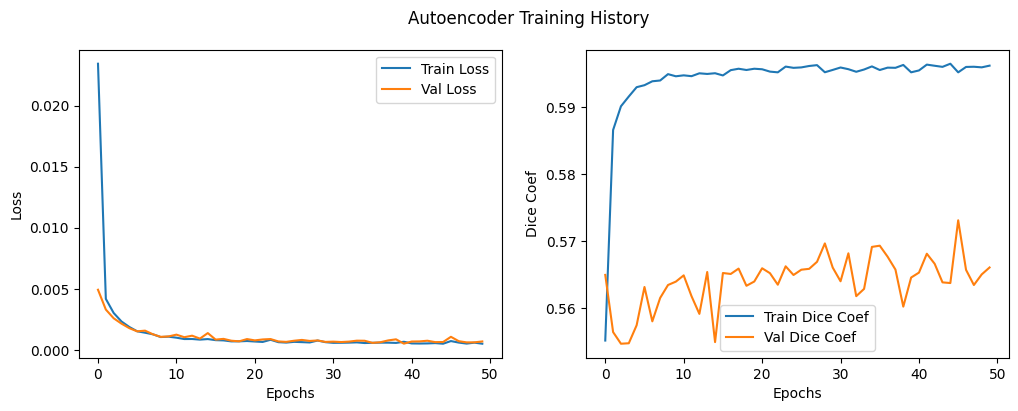

Final Dice Coef: 0.573093593120575


In [12]:
plot_results(AE_history,'Autoencoder').show()
print("Final Dice Coef: " + str(max(AE_history.history['val_dice_coef'])))

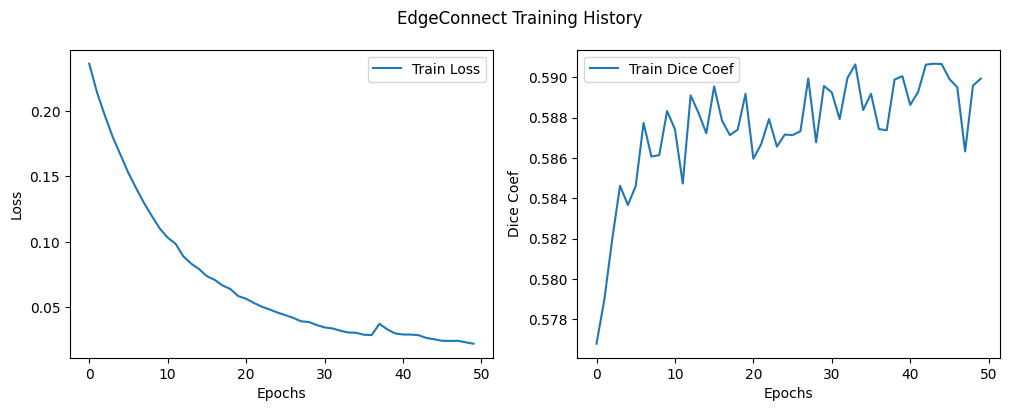

In [13]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('EdgeConnect Training History')

epochs = len(EC_history['loss'])
plt.subplot(1, 2, 1)
plt.plot(range(epochs), EC_history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs),EC_history['dice_coef'],label='Train Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()

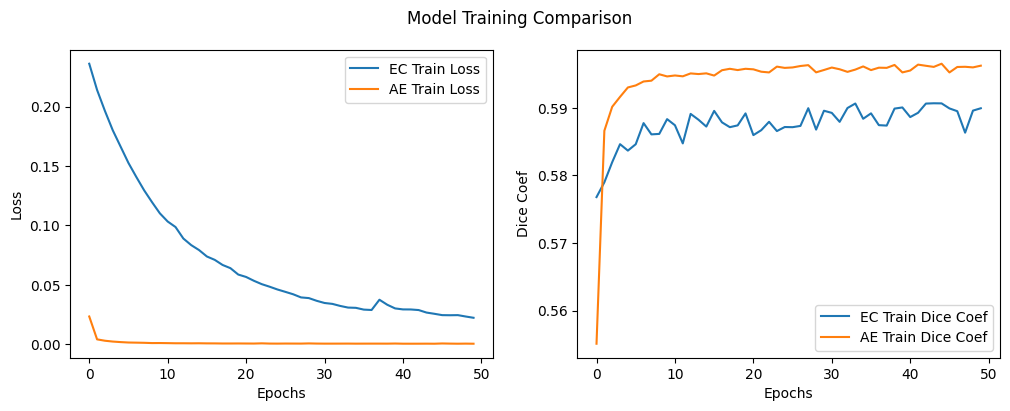

In [14]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Model Training Comparison')

epochs = len(EC_history['loss'])
plt.subplot(1, 2, 1)
plt.plot(range(epochs), EC_history['loss'], label='EC Train Loss')
plt.plot(range(epochs), AE_history.history['loss'],label='AE Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs),EC_history['dice_coef'],label='EC Train Dice Coef')
plt.plot(range(epochs), AE_history.history['dice_coef'],label='AE Train Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()

## Plot example images

In [15]:
# Define the transforms to apply to the images and masks
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images and masks to tensors
    transforms.Resize((256, 256)),  # Resize images and masks to the target size
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Normalize images and masks to be in [0, 1]
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

1/1 [==============================] - 0s 17ms/step


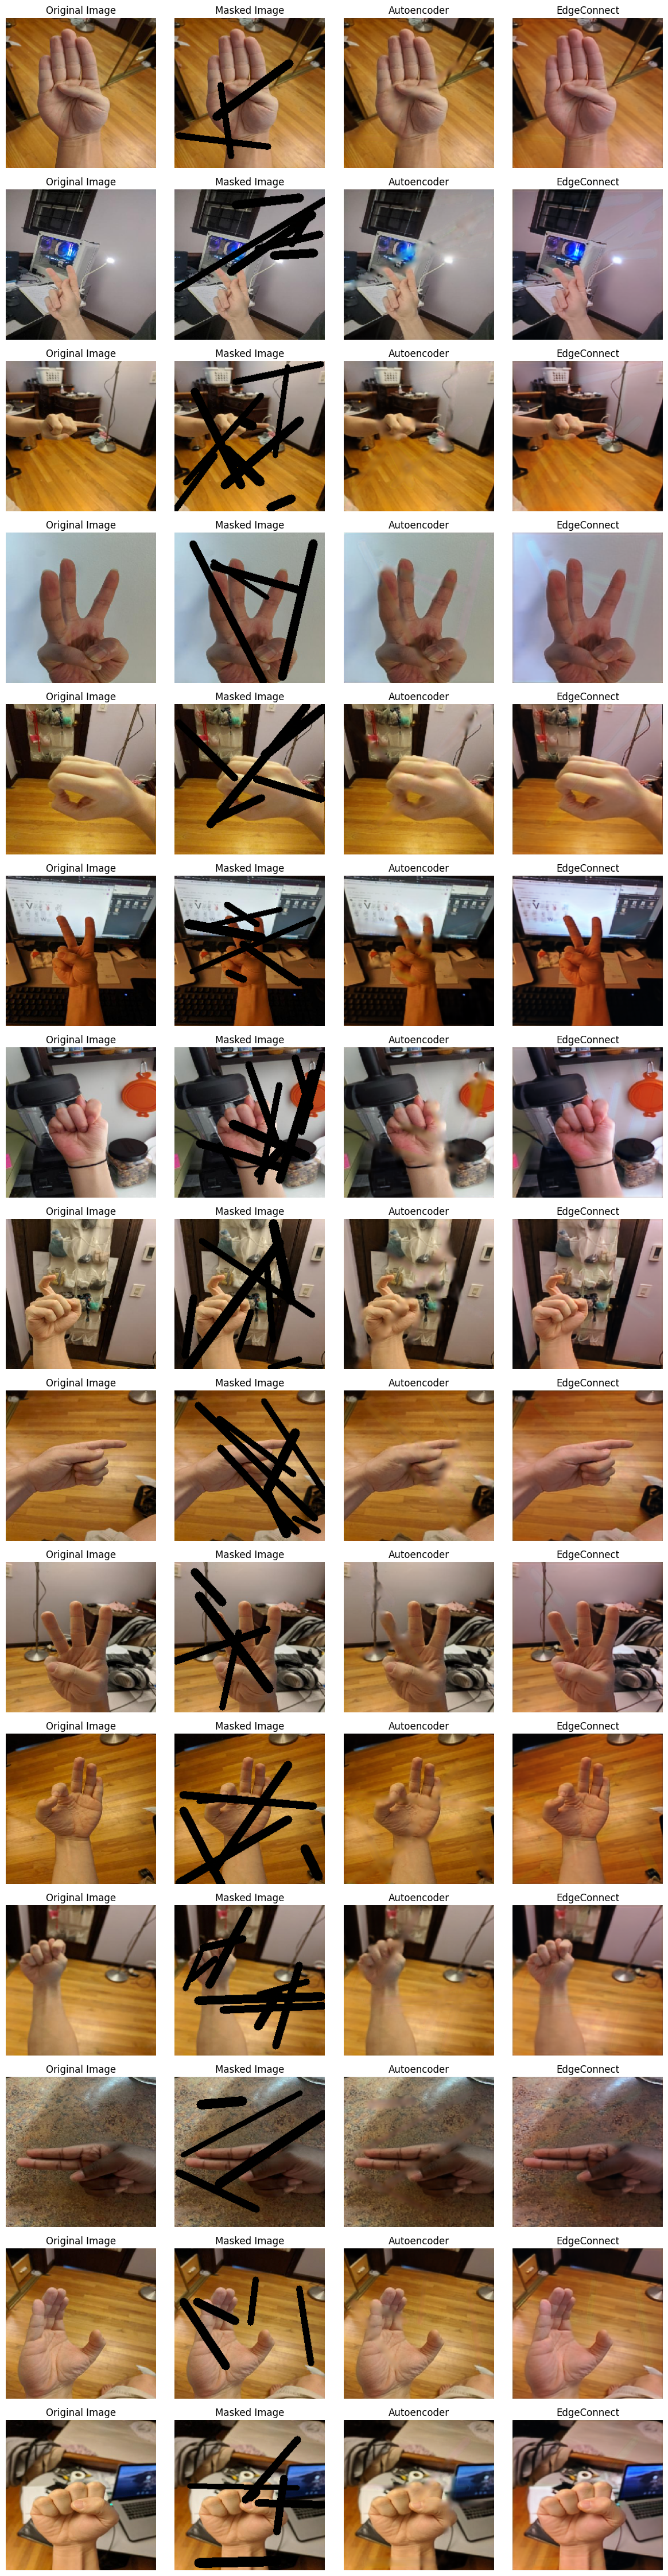

In [31]:
rows = 15
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(12, 3 * rows))

model.eval()

metrics = {'AE_loss':[],'AE_dice_coef':[],'EC_loss':[],'EC_dice_coef':[]}

# Suppress warnings
warnings.filterwarnings("ignore")

with torch.no_grad():
    for i in range(x_test.shape[0]):
        #mask image
        masked_image, mask = mask_image(x_test[i])
        
        # Autoencoder predict
        inpainted_image_keras = AE_model.predict(masked_image.reshape((1,) + masked_image.shape))
        AE_img = inpainted_image_keras.reshape(inpainted_image_keras.shape[1:])

        # EdgeConnect predict
        img_torch = x_test[i]
        mask = cv2.resize(mask, (256, 256))
        mask = Image.fromarray(mask).convert("L")
        img_tensor = transform(img_torch).unsqueeze(0).to(torch.float)
        mask_tensor = mask_transform(mask).unsqueeze(0)
        img_with_mask = torch.cat((img_tensor, mask_tensor), dim=1)
        img_with_mask = img_with_mask.to(device)
        _, completion_torch = model(img_with_mask)
        completion_torch = completion_torch.cpu().numpy().transpose(0, 2, 3, 1)
        
        # Calculate metrics for Autoencoder
        ae_loss = mean_squared_error((x_test[i]/255).reshape(-1, x_test.shape[-1]),
                                     AE_img.reshape(-1, AE_img.shape[-1]))
        metrics['AE_loss'].append(ae_loss)
        
        metrics['AE_dice_coef'].append(dice_coef(x_test[i]/255,AE_img))

        # Calculate metrics for EdgeConnect
        ec_loss = mean_squared_error((x_test[i]/255).reshape(-1, x_test.shape[-1]),
                                     completion_torch[0].reshape(-1, completion_torch[0].shape[-1]))
        metrics['EC_loss'].append(ec_loss)
        metrics['EC_dice_coef'].append(dice_coef(x_test[i]/255,completion_torch[0]))

        if i < rows:
        # Plot the images
            axs[i][0].imshow(x_test[i])
            axs[i][0].set_title('Original Image')
            axs[i][0].axis('off')

            axs[i][1].imshow(masked_image)
            axs[i][1].set_title('Masked Image')
            axs[i][1].axis('off')

            axs[i][2].imshow(AE_img)
            axs[i][2].set_title('Autoencoder')
            axs[i][2].axis('off')

            axs[i][3].imshow(completion_torch[0])
            axs[i][3].set_title('EdgeConnect')
            axs[i][3].axis('off')

    plt.tight_layout()
    plt.show()

# Reset warning behavior to default
warnings.filterwarnings("default")

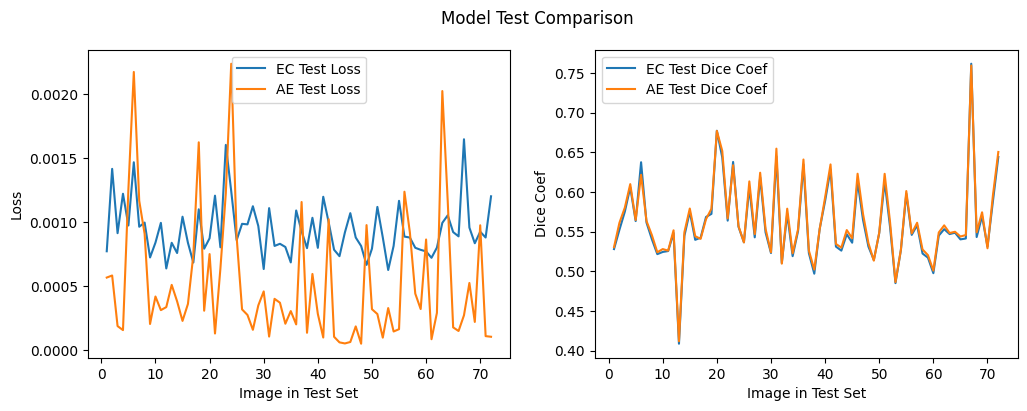

In [28]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Model Test Comparison')

num_images = len(metrics['AE_loss'])
plt.subplot(1, 2, 1)
plt.plot(range(1,num_images+1), metrics['EC_loss'], label='EC Test Loss')
plt.plot(range(1,num_images+1), metrics['AE_loss'],label='AE Test Loss')
plt.xlabel('Image in Test Set')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1,num_images+1),metrics['EC_dice_coef'],label='EC Test Dice Coef')
plt.plot(range(1,num_images+1), metrics['AE_dice_coef'],label='AE Test Dice Coef')
plt.xlabel('Image in Test Set')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()